In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import optim

In [2]:
# Reading data
df = pd.read_csv('./data/temp.csv')
df
# column of actual is y, others are input features.

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41
...,...,...,...,...,...,...,...,...,...
343,2016,12,27,Tues,42,42,45.2,47,47
344,2016,12,28,Wed,42,47,45.3,48,58
345,2016,12,29,Thurs,47,48,45.3,48,65
346,2016,12,30,Fri,48,48,45.4,57,42


数据表中：

* year,moth,day,week分别表示的具体的时间
* temp_2：前天的最高温度值
* temp_1：昨天的最高温度值
* average：在历史中，每年这一天的平均最高温度值
* actual：这就是我们的标签值了，当天的真实最高温度
* friend：这一列可能是凑热闹的，你的朋友猜测的可能值，咱们不管它就好了

In [3]:
df.shape

(348, 9)

In [4]:
# handle time series columns
import datetime


def get_time(s):
    timer = '-'.join(list(map(lambda x: str(x), [s['year'], s['month'], s['day']])))
    timer = datetime.datetime.strptime(timer, '%Y-%m-%d')
    return timer


df.apply(get_time, axis=1)

0     2016-01-01
1     2016-01-02
2     2016-01-03
3     2016-01-04
4     2016-01-05
         ...    
343   2016-12-27
344   2016-12-28
345   2016-12-29
346   2016-12-30
347   2016-12-31
Length: 348, dtype: datetime64[ns]

In [5]:
plot_cols = ['actual', 'temp_1', 'temp_2', 'friend']

<Figure size 640x480 with 0 Axes>

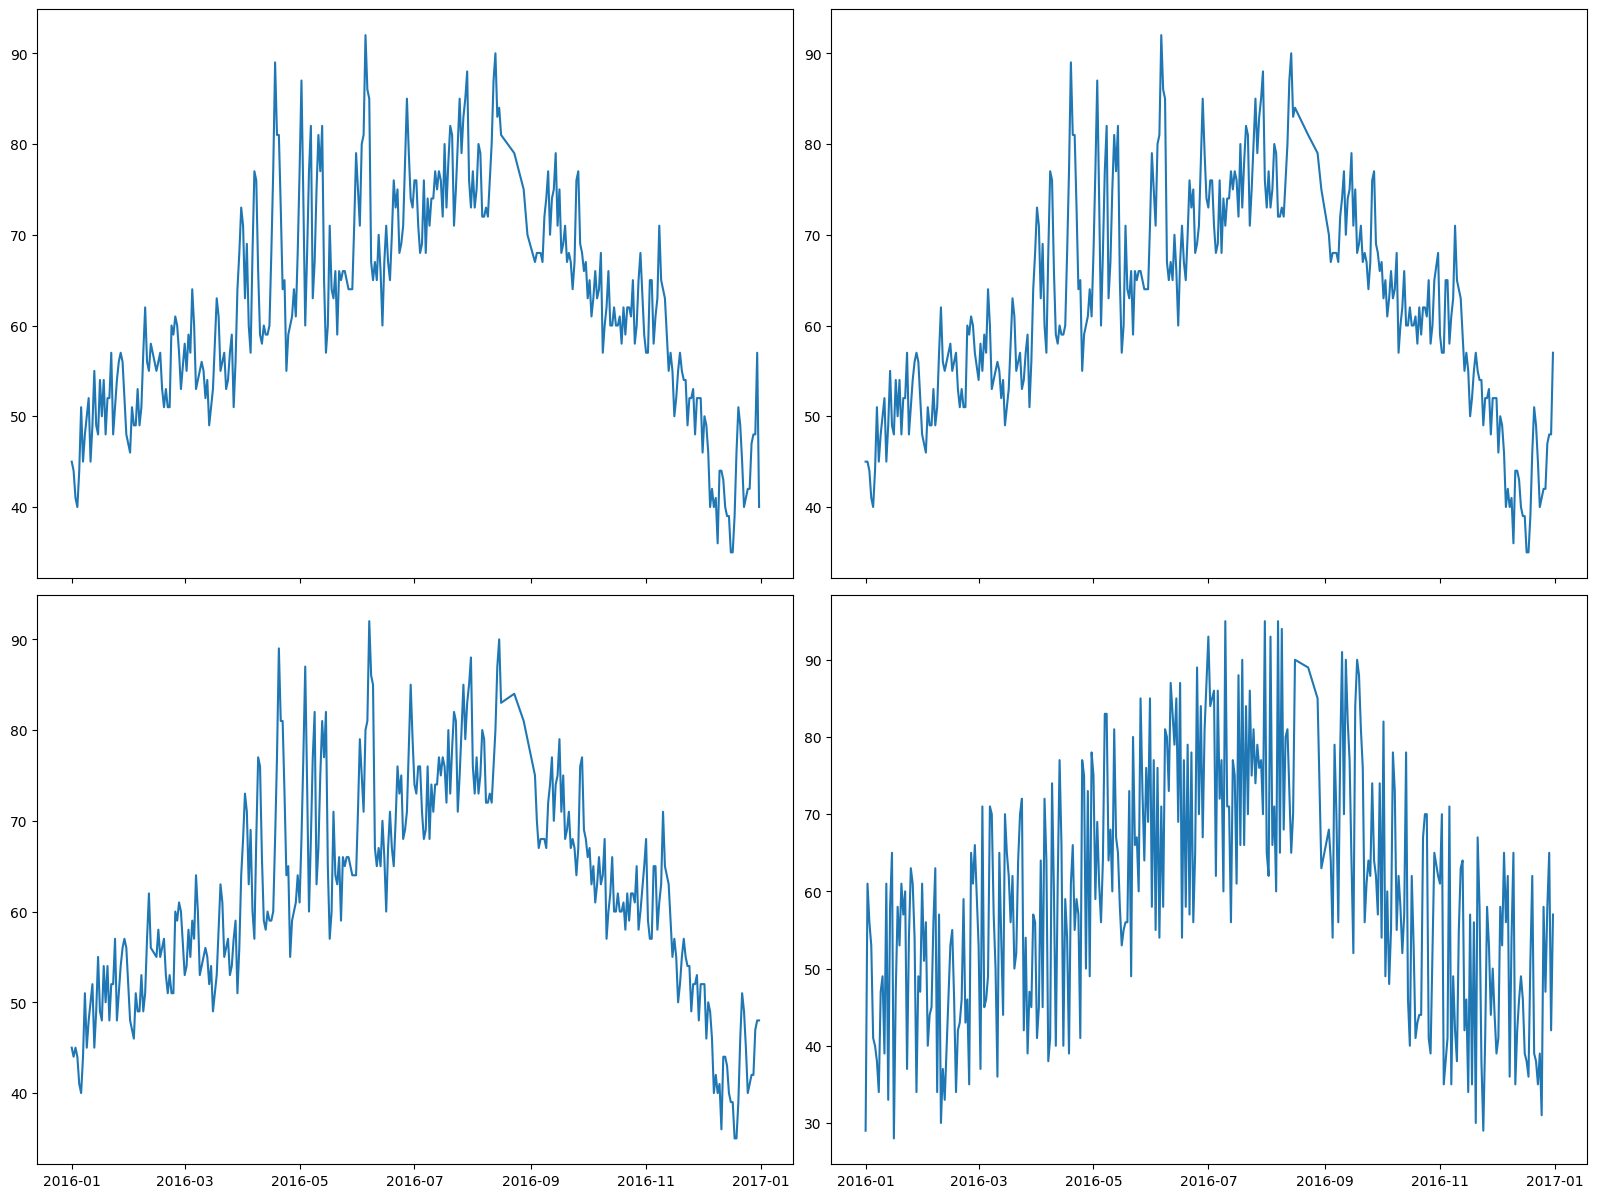

In [6]:
plt.figure(dpi=100)
fig, ax_arr = plt.subplots(2, 2, sharex='all', figsize=(20, 15))
fig.subplots_adjust(hspace=0.03, wspace=0.05)

for i in range(ax_arr.shape[0]):
    for j in range(ax_arr.shape[1]):
        ax_arr[i, j].plot(df.apply(get_time, axis=1), df[plot_cols[i * 2 + j]])

In [7]:
df
# 需要对多分类列week进行独热编码

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41
...,...,...,...,...,...,...,...,...,...
343,2016,12,27,Tues,42,42,45.2,47,47
344,2016,12,28,Wed,42,47,45.3,48,58
345,2016,12,29,Thurs,47,48,45.3,48,65
346,2016,12,30,Fri,48,48,45.4,57,42


In [8]:
df = pd.get_dummies(df)
df

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,True,False,False,False,False,False,False
1,2016,1,2,44,45,45.7,44,61,False,False,True,False,False,False,False
2,2016,1,3,45,44,45.8,41,56,False,False,False,True,False,False,False
3,2016,1,4,44,41,45.9,40,53,False,True,False,False,False,False,False
4,2016,1,5,41,40,46.0,44,41,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,2016,12,27,42,42,45.2,47,47,False,False,False,False,False,True,False
344,2016,12,28,42,47,45.3,48,58,False,False,False,False,False,False,True
345,2016,12,29,47,48,45.3,48,65,False,False,False,False,True,False,False
346,2016,12,30,48,48,45.4,57,42,True,False,False,False,False,False,False


In [9]:
y = np.array(df['actual'])  # 预测变量
y

array([45, 44, 41, 40, 44, 51, 45, 48, 50, 52, 45, 49, 55, 49, 48, 54, 50,
       54, 48, 52, 52, 57, 48, 51, 54, 56, 57, 56, 52, 48, 47, 46, 51, 49,
       49, 53, 49, 51, 57, 62, 56, 55, 58, 55, 56, 57, 53, 51, 53, 51, 51,
       60, 59, 61, 60, 57, 53, 58, 55, 59, 57, 64, 60, 53, 54, 55, 56, 55,
       52, 54, 49, 51, 53, 58, 63, 61, 55, 56, 57, 53, 54, 57, 59, 51, 56,
       64, 68, 73, 71, 63, 69, 60, 57, 68, 77, 76, 66, 59, 58, 60, 59, 59,
       60, 68, 77, 89, 81, 81, 73, 64, 65, 55, 59, 60, 61, 64, 61, 68, 77,
       87, 74, 60, 68, 77, 82, 63, 67, 75, 81, 77, 82, 65, 57, 60, 71, 64,
       63, 66, 59, 66, 65, 66, 66, 65, 64, 64, 64, 71, 79, 75, 71, 80, 81,
       92, 86, 85, 67, 65, 67, 65, 70, 66, 60, 67, 71, 67, 65, 70, 76, 73,
       75, 68, 69, 71, 78, 85, 79, 74, 73, 76, 76, 71, 68, 69, 76, 68, 74,
       71, 74, 74, 77, 75, 77, 76, 72, 80, 73, 78, 82, 81, 71, 75, 80, 85,
       79, 83, 85, 88, 76, 73, 77, 73, 75, 80, 79, 72, 72, 73, 72, 76, 80,
       87, 90, 83, 84, 81

In [10]:
# 特征矩阵
X = np.array(df.drop('actual', axis=1))
X

array([[2016, 1, 1, ..., False, False, False],
       [2016, 1, 2, ..., False, False, False],
       [2016, 1, 3, ..., False, False, False],
       ...,
       [2016, 12, 29, ..., True, False, False],
       [2016, 12, 30, ..., False, False, False],
       [2016, 12, 31, ..., False, False, False]], dtype=object)

In [11]:
X.shape, y.shape

((348, 14), (348,))

In [12]:
# 特征标准化
from sklearn import preprocessing

X = preprocessing.StandardScaler().fit_transform(X)
X

array([[ 0.        , -1.5678393 , -1.65682171, ..., -0.40482045,
        -0.41913682, -0.40482045],
       [ 0.        , -1.5678393 , -1.54267126, ..., -0.40482045,
        -0.41913682, -0.40482045],
       [ 0.        , -1.5678393 , -1.4285208 , ..., -0.40482045,
        -0.41913682, -0.40482045],
       ...,
       [ 0.        ,  1.5810006 ,  1.53939107, ...,  2.47023092,
        -0.41913682, -0.40482045],
       [ 0.        ,  1.5810006 ,  1.65354153, ..., -0.40482045,
        -0.41913682, -0.40482045],
       [ 0.        ,  1.5810006 ,  1.76769198, ..., -0.40482045,
        -0.41913682, -0.40482045]])

In [13]:
# 构建神经网络模型
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [14]:
# 权重、偏置参数初始化（随机正态分布）
weight_00 = torch.randn((14, 128), dtype=torch.float32, requires_grad=True)
biases_00 = torch.randn(128, dtype=torch.float32, requires_grad=True)

weight_01 = torch.randn((128, 1), dtype=torch.float32, requires_grad=True)
biases_01 = torch.randn(1, dtype=torch.float32, requires_grad=True)
# 输入Input为[348, 14]，第一个权重为[14， 128]，相乘之后为[348, 128]，每一列都需要有个偏置，因此偏置为[128, 1]

In [15]:
learning_rate = 0.001
loss = []

for i in range(1000):
    # 隐藏层计算
    hidden = X.mm(weight_00) + biases_00
    # 激活函数
    hidden = torch.relu(hidden)

    # 输出层计算
    y_pred = hidden.mm(weight_01) + biases_01

    # 计算损失
    cur_loss = torch.mean((y_pred - y) ** 2)
    loss.append(cur_loss.item())

    if not i % 100:
        print(f'{i} Loss is {cur_loss}.')

    # 反向传播
    cur_loss.backward()

    # 更新参数
    weight_00.data.add_(-learning_rate * weight_00.grad.data)
    biases_00.data.add_(-learning_rate * biases_00.grad.data)
    weight_01.data.add_(-learning_rate * weight_01.grad.data)
    biases_01.data.add_(-learning_rate * biases_01.grad.data)

    # 每次迭代完成，记得清空梯度
    weight_00.grad.zero_()
    biases_00.grad.zero_()
    weight_01.grad.zero_()
    biases_01.grad.zero_()

0 Loss is 4525.73974609375.
100 Loss is 156.73556518554688.
200 Loss is 148.74534606933594.
300 Loss is 145.8725128173828.
400 Loss is 144.28282165527344.
500 Loss is 143.2707061767578.
600 Loss is 142.55967712402344.
700 Loss is 142.01930236816406.
800 Loss is 141.59912109375.
900 Loss is 141.27589416503906.


In [16]:
loss

[4525.73974609375,
 886.3401489257812,
 594.748291015625,
 489.01416015625,
 424.45440673828125,
 380.58270263671875,
 349.24896240234375,
 325.9738464355469,
 308.0195007324219,
 293.77435302734375,
 282.1092224121094,
 272.3055419921875,
 263.8709716796875,
 256.4747009277344,
 249.90682983398438,
 244.0129852294922,
 238.68374633789062,
 233.8388671875,
 229.4170684814453,
 225.36163330078125,
 221.6199951171875,
 218.15025329589844,
 214.92149353027344,
 211.90383911132812,
 209.08493041992188,
 206.45127868652344,
 203.98794555664062,
 201.68174743652344,
 199.5183868408203,
 197.48924255371094,
 195.58152770996094,
 193.78329467773438,
 192.0880584716797,
 190.4821014404297,
 188.96575927734375,
 187.5322723388672,
 186.17727661132812,
 184.89703369140625,
 183.686279296875,
 182.53749084472656,
 181.44216918945312,
 180.4014892578125,
 179.4119110107422,
 178.46795654296875,
 177.56588745117188,
 176.70797729492188,
 175.89080810546875,
 175.1110076904297,
 174.36534118652344,
 

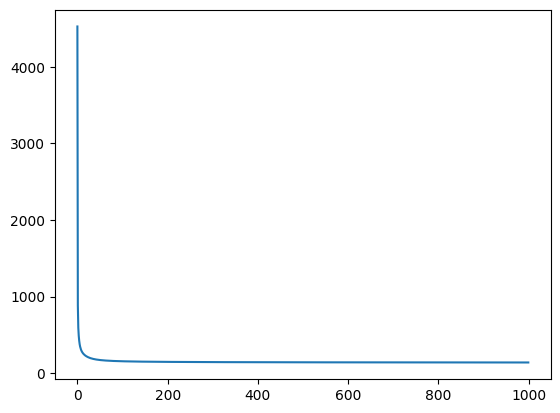

In [17]:
plt.plot(loss)

In [20]:
# 更简单的一种方法构建网络模型
feature_size = X.shape[1]
hidden_size = 128
output_size = 1
batch_size = 16

In [45]:
from torch.nn import Sequential, Linear, Sigmoid, MSELoss

model = Sequential(
    Linear(feature_size, hidden_size),
    Sigmoid(),
    Linear(hidden_size, output_size)
)

loss_fun = MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [46]:
# 训练网络
loss = []

for i in range(1000):
    batch_loss = []
    # 使用Mini-batch进行随机梯度下降
    for start_index in range(0, len(X), batch_size):
        end_index = start_index + batch_size if start_index + batch_size < len(X) else len(X)
        # batch_X = torch.tensor(X.clone().detach()[start_index:end_index], dtype=torch.float32, requires_grad=True)
        # batch_y = torch.tensor(y.clone().detach()[start_index:end_index], dtype=torch.float32, requires_grad=True).unsqueeze(-1)
        batch_X = X[start_index:end_index].clone().detach().requires_grad_(True)
        batch_y = y[start_index:end_index].unsqueeze(-1).clone().detach().requires_grad_(True)

        batch_y_pred = model(batch_X)
        cur_loss = loss_fun(batch_y, batch_y_pred)
        cur_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        batch_loss.append(cur_loss.item())

    loss.append(np.mean(batch_loss))
    if not i % 100:
        print(f'{i} Loss is {np.mean(batch_loss)}.')

0 Loss is 4028.386308149858.
100 Loss is 23.25373101234436.
200 Loss is 20.736754179000854.
300 Loss is 19.75671341202476.
400 Loss is 18.99039511247115.
500 Loss is 18.183095346797597.
600 Loss is 17.36198592185974.
700 Loss is 16.550354394045744.
800 Loss is 15.742714166641235.
900 Loss is 14.923733537847346.


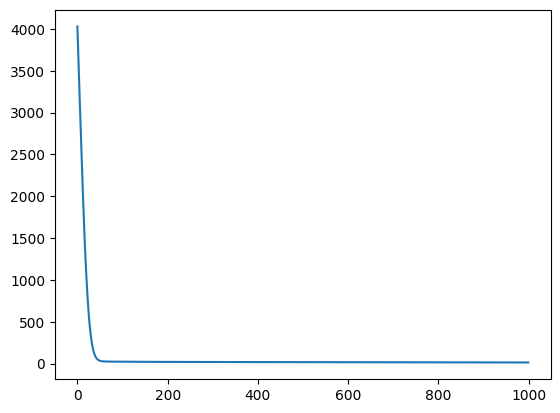

In [47]:
plt.plot(loss)

In [35]:
# 预测训练效果


torch.Size([2])

In [37]:
a.unsqueeze(-1).shape

torch.Size([2, 1])